### Importing Libraries

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz
import re
from pyvis.network import Network
import json
import os
import requests

### Making the Query with Twarc

This documentation (https://twarc-project.readthedocs.io/en/latest/twarc2_en_us/) is useful in looking at the various parameters and arguments you can use to make a query. (The os library is used here, but you can do this in your command line as well).

In [2]:
os.system('twarc2 searches --limit 2000 search.text > ms_tweets.jsonl')
# search.text contains the query 'mass shooting'

0

There are various outputs to get your network from the queried tweets. The default that twarc network produces is html, but there are many other possible outputs. Here I use the csv file that contains the edgelist for the network, as I found that was easiest to use in a Jupyter notebook. 

The --min-component-size argument here restricts the network to contain only nodes with at least 5 connections(which I added to simplify the network). Conversely, there is also --max-component-size which limits the network to only have nodes with at most that many connections.

In [3]:
os.system('twarc2 network ms_tweets.jsonl --format csv ms_network.csv --min-component-size 5')

0

### Reading the Edgelist in + Visualization and Analysis

The source and target columns are the nodes for the edges, while weight, retweet, reply, quote, and mention can be the different weights for the edges(weight is the sum of the other 4).

In [4]:
colnames=['Source', 'Target', 'weight', 'retweet', 'reply', 'quote', 'mention'] 
Panda_edgelist = pd.read_csv('ms_network.csv', names=colnames, header=None)

Panda_edgelist['weight'] = Panda_edgelist['weight'].apply(lambda weight: int(re.findall(r'\d+', weight)[0]))
Panda_edgelist['retweet'] = Panda_edgelist['retweet'].apply(lambda weight: int(re.findall(r'\d+', weight)[0]))
Panda_edgelist['reply'] = Panda_edgelist['reply'].apply(lambda weight: int(re.findall(r'\d+', weight)[0]))
Panda_edgelist['quote'] = Panda_edgelist['quote'].apply(lambda weight: int(re.findall(r'\d+', weight)[0]))
Panda_edgelist['mention'] = Panda_edgelist['mention'].apply(lambda weight: int(re.findall(r'\d+', weight)[0]))
Panda_edgelist

,Source,Target,weight,retweet,reply,quote,mention
0,kelownascott,1MikeMorris,1,1,0,0,0
1,kelownascott,BestStephenD,2,1,0,0,1
2,1MikeMorris,BestStephenD,3,1,1,0,1
3,1MikeMorris,DavidHamer_1951,2,0,1,0,1
4,1MikeMorris,asmarshall83,1,0,0,0,1
...,...,...,...,...,...,...,...
2022,PlakkiePlak,Lauren_Southern,1,1,0,0,0
2023,onedayoneday77,BetoORourke,1,1,0,0,0
2024,NobleJtnalger,BetoORourke,1,1,0,0,0
2025,sdsengineer,BetoORourke,1,1,0,0,0


Here, I use the networkx library to visualize the network first, but networkx really isn't visualization library, but more for analysis. 

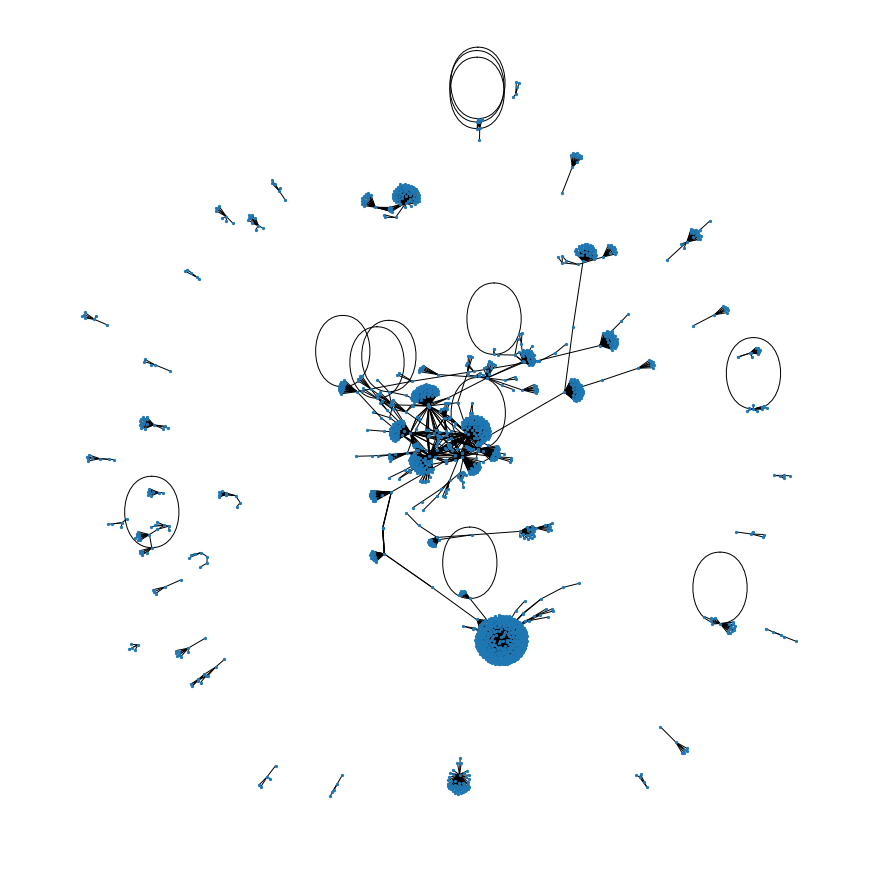

In [5]:
g = nx.from_pandas_edgelist(Panda_edgelist, 'Source', 'Target', edge_attr='weight')

plt.figure(3,figsize=(12,12)) 
nx.draw(g, node_size = 5, with_labels = False)

This prints the basic info about the network.

In [6]:
print(nx.info(g))

Graph with 1752 nodes and 2021 edges


C:\Users\aviko\AppData\Local\Temp\ipykernel_190440\1432719896.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


To visualize the network, I found the pyvis library to be the best.  It allows for interaction with the visualized network within the notebook, but keep in mind, as the networks get larger and more complex, depending on your device it can become quite slow. 

In [7]:
net = Network(notebook=True)
net.from_nx(g)
net.show('ms_network1.html')

The density of the network is a measure of the network that shows how many edges currently exist, out of the total number of possible edges. 

In [8]:
density = nx.density(g)

print('The edge density is: ' + str(density))

The edge density is: 0.0013175771705144354


This code provides the average degree, which is the sum of the degrees of all its nodes divided by the number of nodes in the graph.

In [9]:
degree = g.degree()

degree_list = []

for (n,d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)

print('The average degree is ' + str(av_degree))

The average degree is 2.307077625570776


This is a plot of the distribution of the degrees in the network.

In [10]:
sorted(g.degree, key=lambda x: x[1], reverse=True)[0:10]

[('BetoORourke', 440),
 ('sunlorrie', 148),
 ('TWilsonOttawa', 113),
 ('WeAreCanProud', 100),
 ('TrueNorthCentre', 77),
 ('tweettopals1', 77),
 ('ChrisLewisLLS', 55),
 ('chluke1967', 50),
 ('ABC', 45),
 ('nspector4', 42)]

Text(0.5, 1.0, 'Node Degree Distribution')

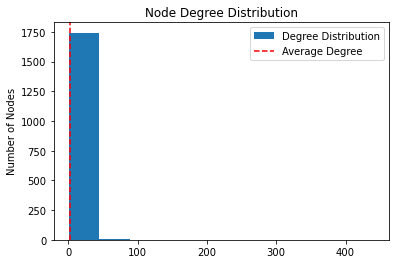

In [11]:
plt.hist(degree_list,label='Degree Distribution')
plt.axvline(av_degree,color='r',linestyle='dashed',label='Average Degree')
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('Node Degree Distribution')

This is code that works with the clustering coefficient of the network, which is a measure that shows the tendency of a nodes to cluster together in the network.  

In [12]:
# Clustering coefficient of node 
print(nx.clustering(g, 'BetoORourke'))
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(g)
# Average clustering coefficient
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
print(avg_clust)
# Or use directly the built-in method
print(nx.average_clustering(g))

1.0354110581901015e-05
0.06602268308018902
0.06602268308018902


This is the distribution of the local clustering coefficient in the network. 

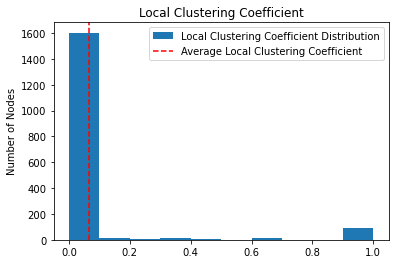

In [13]:
local_clustering_coefficient = nx.algorithms.cluster.clustering(g)

av_local_clustering_coefficient = sum(local_clustering_coefficient.values())/len(local_clustering_coefficient)

plt.hist(local_clustering_coefficient.values(),label='Local Clustering Coefficient Distribution')
plt.axvline(av_local_clustering_coefficient,color='r',linestyle='dashed',label='Average Local Clustering Coefficient')
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('Local Clustering Coefficient')
plt.show()

Here , I am using modularity optimization to detect communities within the network(of which there are 56 in the network).

In [14]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

c = list(greedy_modularity_communities(g))

print(len(c))

54


I then built a dictionary so we can access each community that is detected, where an example is community_10.

In [15]:
obj = {}
i = 0
for community in c:
    obj['community_'+str(i)] = sorted(c[i])
    i+=1

In [16]:
obj['community_10']

['0DSLMS',
 '8NEWS',
 'AnthonyTuanNgu1',
 'AriesBeal202',
 'BNNCA',
 'BonginkosiD3',
 'CalebJHull',
 'ChicagoContrar1',
 'Dagmar49789411',
 'DarickR',
 'Dumayavu_Velly',
 'EricCHenry_',
 'EversonLuhanga',
 'Florencetintsw1',
 'ForAllSouthAfr1',
 'JackPosobiec',
 'JefferyMadewell',
 'LeeDaws19',
 'Marianna9110',
 'OrderofTheDimen',
 'Samforpasenate',
 'SaycheeseDGTL',
 'SharinStone',
 'Shawn80654585',
 'SirPantyhose',
 'SteveGrzanich',
 'TimRunsHisMouth',
 'Transctimes',
 'Xoliswa44812710',
 'Zucoki',
 '_EbenezerMensah',
 'babushkakov',
 'kgburke3',
 'mahmoodhaffy',
 'mazemoore',
 'mig30m6',
 'nypost',
 'prisky_asare',
 'sleepmane',
 'truth_vibration',
 'veizzes']

Here, I use networkx to build a tree from breadth-first search, that shows how you can get to all other connected node from one node(in this case, the nypost node).

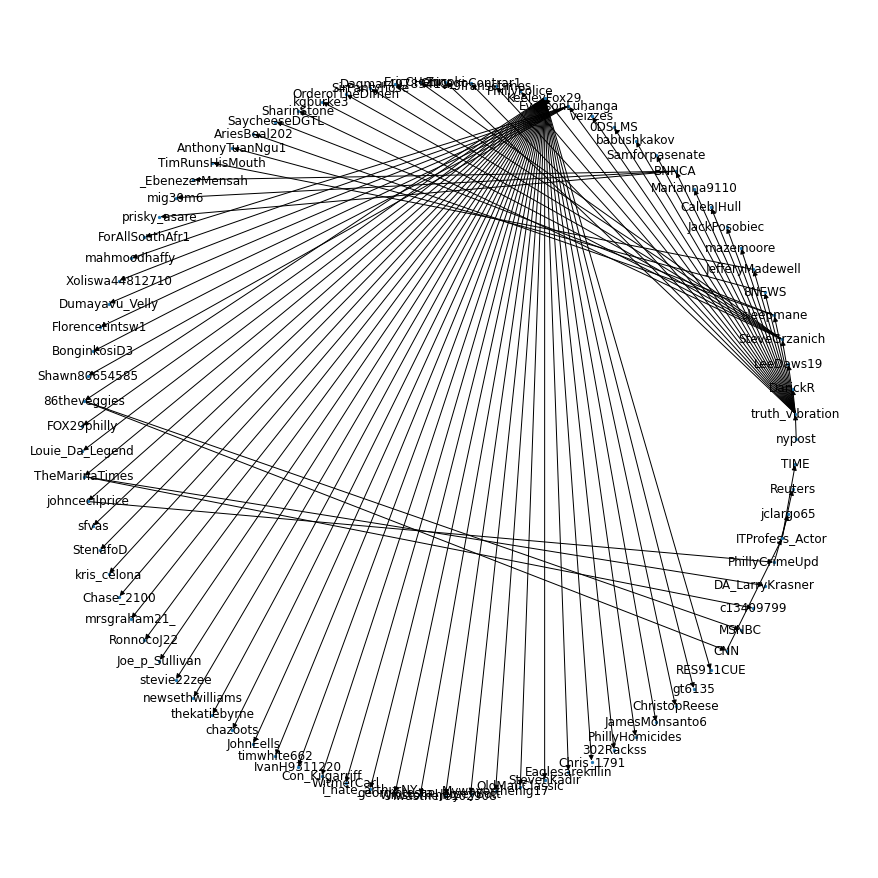

In [19]:
T = nx.bfs_tree(g, 'nypost')
plt.figure(3,figsize=(12,12)) 
nx.draw_circular(T, node_size = 5, with_labels = True)
plt.show()

In [20]:
net_t = Network(notebook=True, directed=True)
net_t.from_nx(T)
net_t.show('ms_BFS_T.html')

This next section deals with the centrality measures for networks, which help in showing which nodes are important. There are three types in networkx: degree centrality, eigenvector centrality, and betweeness centrality. For more info on each, look at this link(https://towardsdatascience.com/notes-on-graph-theory-centrality-measurements-e37d2e49550a). The code below displays the top 10 nodes with the highest centrality measures of each type.

In [21]:
for i in sorted(nx.degree_centrality(g), key=nx.degree_centrality(g).get, reverse=True)[0:10]:
    print(i, ':', nx.degree_centrality(g)[i])

BetoORourke : 0.251284980011422
sunlorrie : 0.0845231296402056
TWilsonOttawa : 0.06453455168475157
WeAreCanProud : 0.05711022272986865
TrueNorthCentre : 0.04397487150199886
tweettopals1 : 0.04397487150199886
ChrisLewisLLS : 0.03141062250142775
chluke1967 : 0.028555111364934323
ABC : 0.02569960022844089
nspector4 : 0.023986293546544833


In [22]:
for i in sorted(nx.eigenvector_centrality_numpy(g), key=nx.eigenvector_centrality_numpy(g).get, reverse=True)[0:10]:
    print(i, ':', nx.eigenvector_centrality_numpy(g)[i])

BetoORourke : 0.7067570624795017
Enough27329436 : 0.03604642365102579
WilliamMall : 0.035528402662195105
Ricard_MN : 0.035528402662195105
plethcheckmatic : 0.03453674223378542
hafwaphota : 0.03453674223378539
sylviapataki : 0.03453674223378539
jeffedelstein : 0.03453674223378538
kyonelcalctopk : 0.03453674223378539
preftabacha : 0.034536742233785396


In [23]:
for i in sorted(nx.betweenness_centrality(g), key=nx.betweenness_centrality(g).get, reverse=True)[0:10]:
    print(i, ':', nx.betweenness_centrality(g)[i])

BetoORourke : 0.10799902096761035
sunlorrie : 0.04206259547346475
ThatLibBitch : 0.039545076282940364
drgrinstead : 0.0356550542547116
ABC : 0.03183748062331729
marcody8 : 0.029963612629517827
WeAreCanProud : 0.027738580944346797
TWilsonOttawa : 0.027563927419205304
TrueNorthCentre : 0.021801676362522688
progavalanche : 0.02015044464387697


Below are networks made by varying node size and color by the degree and betweenness centrality of each node. The first network is made by varying color by degree, and size by betweeness centrality. The second network is made by varying color by betweeness centrality and the size by degree.

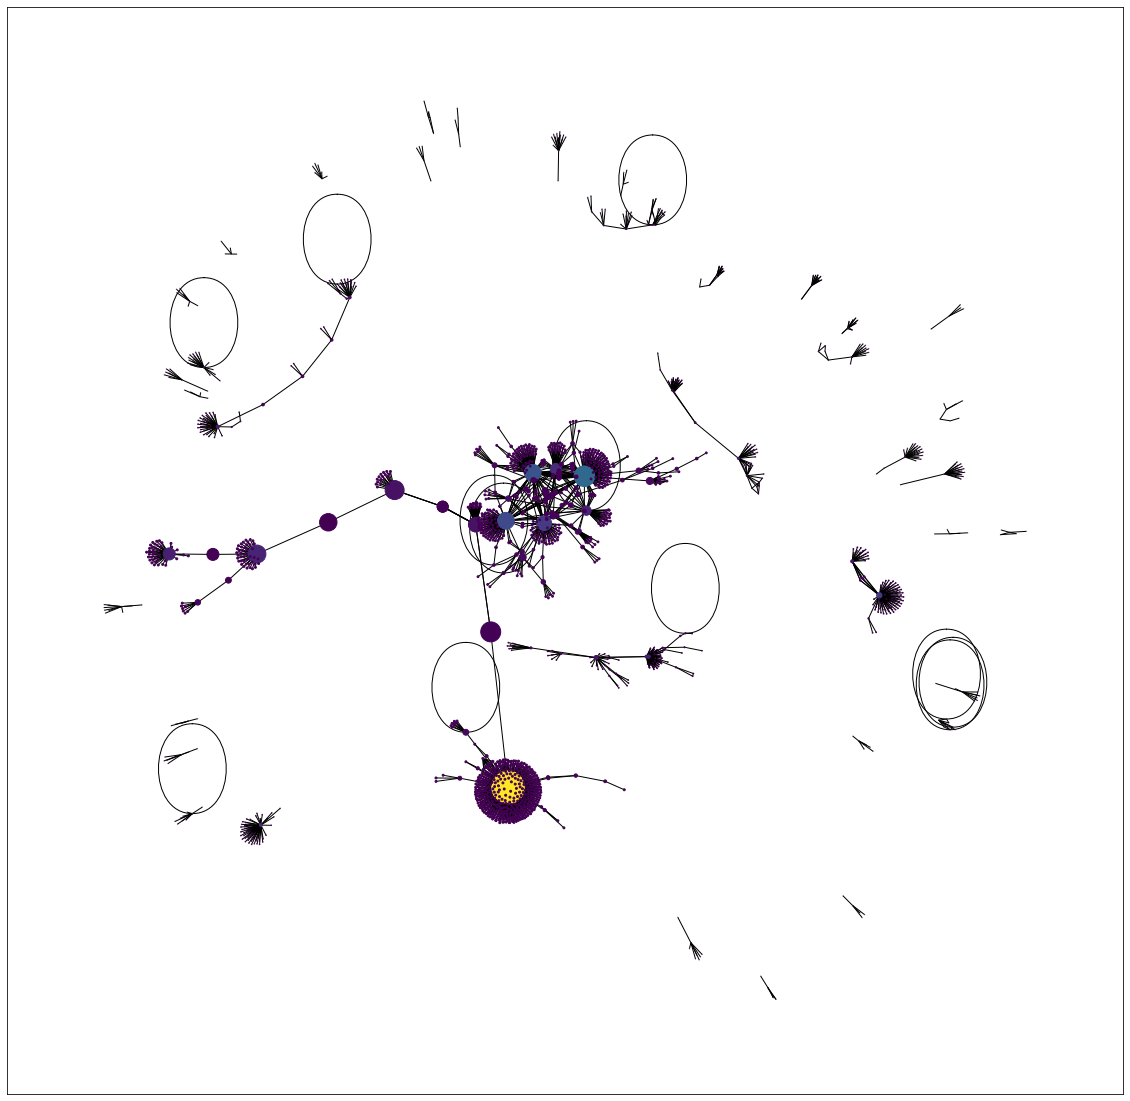

In [24]:
pos = nx.spring_layout(g)
betCent = nx.betweenness_centrality(g, normalized=True, endpoints=True)
node_color = [20000.0 * g.degree(v) for v in g]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )

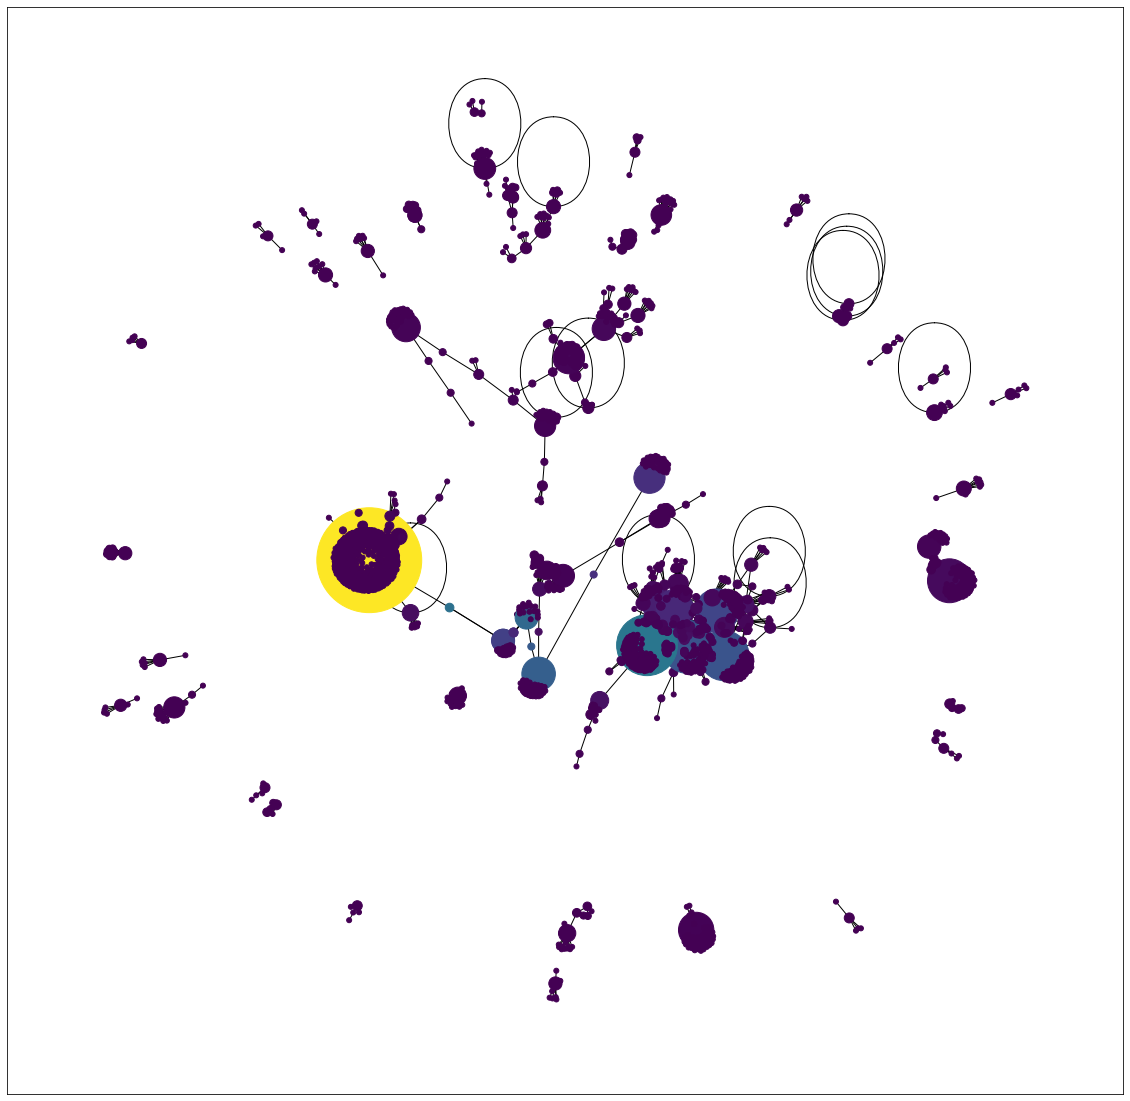

In [25]:
pos = nx.spring_layout(g)
betCent = nx.betweenness_centrality(g, normalized=True, endpoints=True)
node_color = [v * 20000 for v in betCent.values()]
node_size =  [25 * g.degree(v) for v in g]
plt.figure(figsize=(20,20))
nx.draw_networkx(g, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size)

### Changing the Edge Attribute

You can change the network so that the edges are specifically weighted by retweet, quotes, mentions, etc. The network below is weighted by retweets.

In [26]:
g2 = nx.from_pandas_edgelist(Panda_edgelist, 'Source', 'Target', edge_attr='retweet')

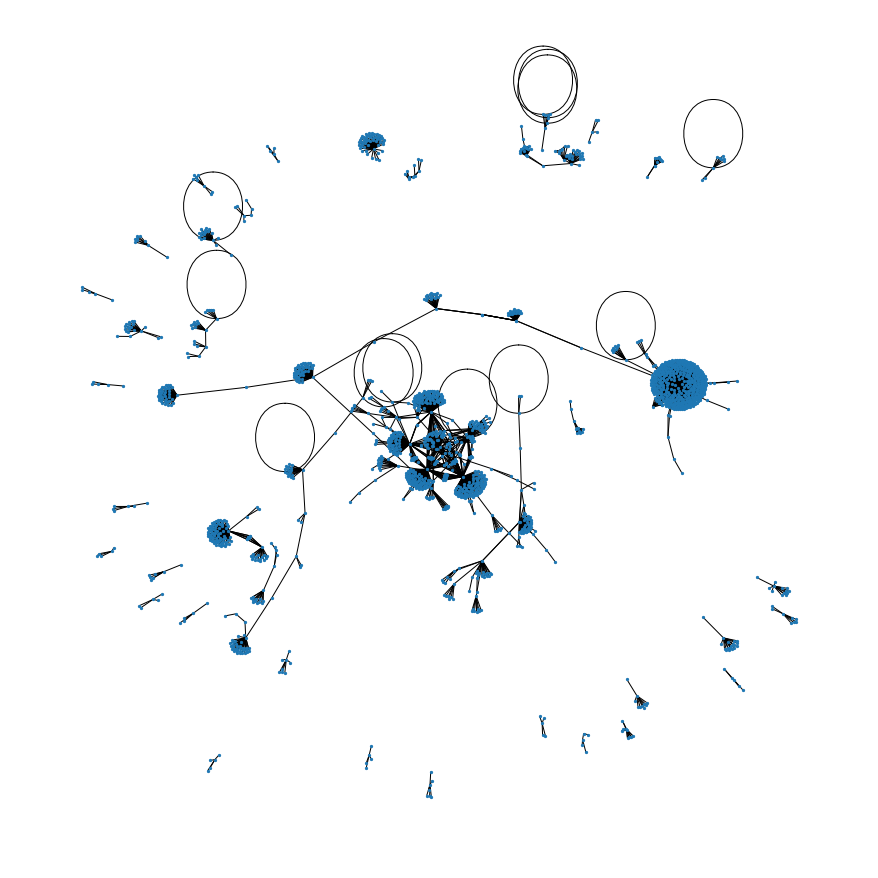

In [27]:
plt.figure(3,figsize=(12,12)) 
nx.draw(g2, node_size = 5, with_labels = False)

In [28]:
print(nx.info(g2))

Graph with 1752 nodes and 2021 edges


C:\Users\aviko\AppData\Local\Temp\ipykernel_190440\689116659.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g2))


In [29]:
net2 = Network(notebook=True)
net2.from_nx(g2)
net2.show('ms_network2.html')

### Changing node type

Twarc network also lets you specify what the nodes are supposed to be. By default, they are users, but you can also do tweets and hashtags. Below, I make a network using tweets as nodes.

In [30]:
os.system('twarc2 network ms_tweets.jsonl --nodes tweets --format csv mstwts_network.csv --min-component-size 5')

0

In [31]:
Panda_edgelist1 = pd.read_csv('mstwts_network.csv', names=colnames, header=None)
Panda_edgelist1

,Source,Target,weight,retweet,reply,quote,mention
0,1559933280337530880,1559881299225092097,{'type': 'retweet'},NaN,NaN,NaN,NaN
1,1559881299225092097,1559876538866212864,{'type': 'reply'},NaN,NaN,NaN,NaN
2,1559933151178149889,1559908077335449604,{'type': 'retweet'},NaN,NaN,NaN,NaN
3,1559908077335449604,1559905522769448965,{'type': 'quote'},NaN,NaN,NaN,NaN
4,1559933110216704000,1559667559548571650,{'type': 'retweet'},NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1539,1559830253194846210,1559558387863621632,{'type': 'retweet'},NaN,NaN,NaN,NaN
1540,1559830203043643396,1559737949561946112,{'type': 'retweet'},NaN,NaN,NaN,NaN
1541,1559829587911004162,1559558387863621632,{'type': 'retweet'},NaN,NaN,NaN,NaN
1542,1559829350660407296,1559558387863621632,{'type': 'retweet'},NaN,NaN,NaN,NaN


In [32]:
g3 = nx.from_pandas_edgelist(Panda_edgelist1, 'Source', 'Target')
print(nx.info(g3))

Graph with 1597 nodes and 1544 edges


C:\Users\aviko\AppData\Local\Temp\ipykernel_190440\2948142268.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g3))


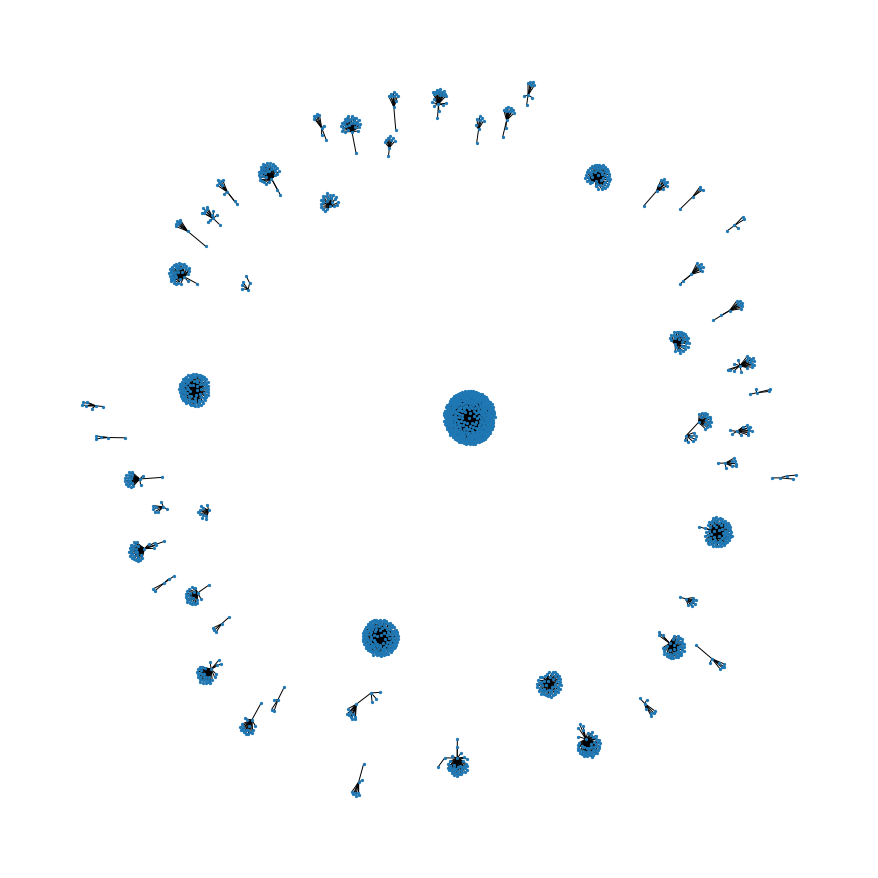

In [33]:
plt.figure(3,figsize=(12,12)) 
nx.draw(g3, node_size = 5, with_labels = False)

In [34]:
net3 = Network(notebook=True)
net3.from_nx(g3)
net3.show('ms_network3.html')